# HTTP3 vs HTTP2 Test Results Visualization
Source: HAR files located under `data/`.

Usage:
```
show_results('data/folder_with_har_files')
```

DE (Nürnberg):
                    HTTP3    HTTP2
median           0.635000  0.54900
mean             0.647211  0.86228
90th percentile  0.755000  1.76600
99th percentile  0.875000  2.06100
min              0.482000  0.42000
max              1.263000  2.19900


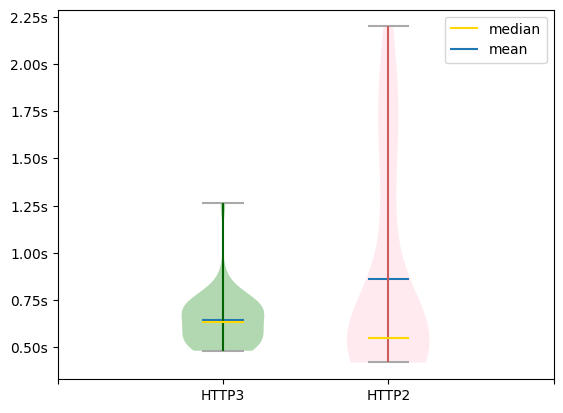

FI (Helsinki):
                    HTTP3     HTTP2
median           0.646500  0.695000
mean             0.670225  0.931714
90th percentile  0.804000  1.796000
99th percentile  0.909000  2.500000
min              0.536000  0.555000
max              0.921000  2.842000


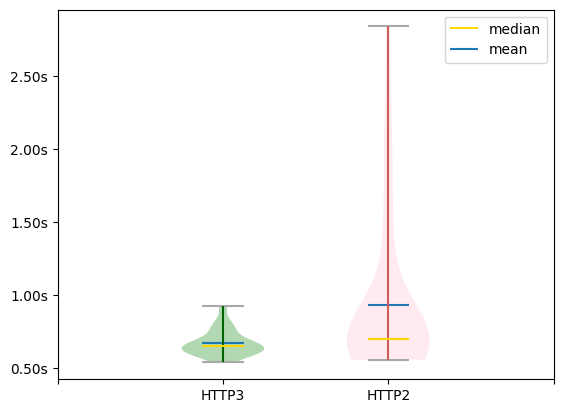

US (East Coast):
                    HTTP3     HTTP2
median           1.280000  1.674000
mean             1.349122  1.794229
90th percentile  1.522000  2.191000
99th percentile  1.921000  2.937000
min              1.143000  1.284000
max              2.173000  4.871000


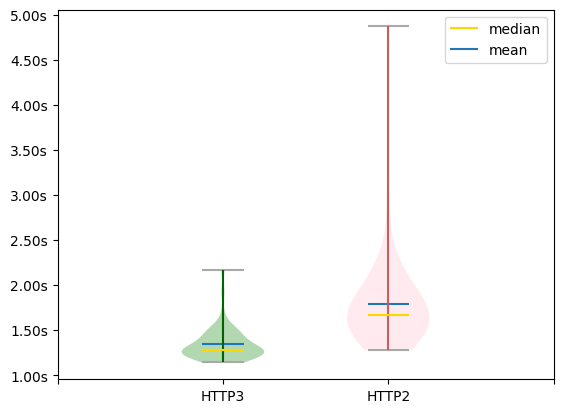

PL (fiber):
                    HTTP3     HTTP2
median           0.839000  0.815500
mean             0.885647  1.011722
90th percentile  1.013000  1.315000
99th percentile  1.014000  1.323000
min              0.753000  0.727000
max              1.428000  2.904000


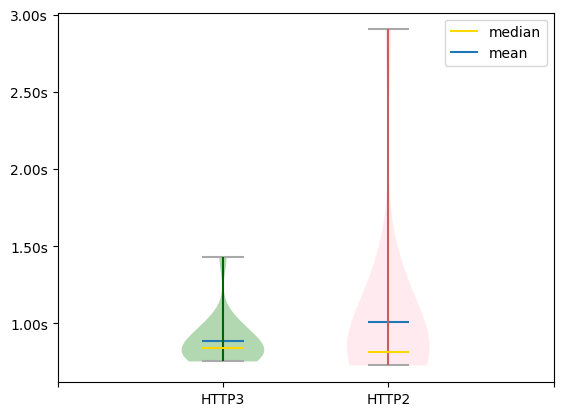

PL mobile LTE:
                    HTTP3   HTTP2
median           1.602000  1.2035
mean             1.717214  1.3895
90th percentile  1.874000  1.5470
99th percentile  2.569000  1.8190
min              1.235000  0.8960
max              2.723000  3.4310


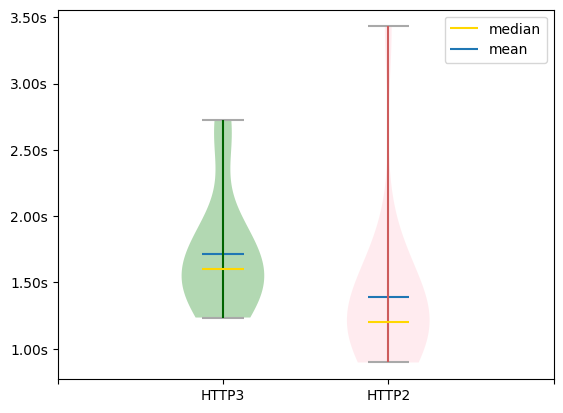

PL mobile poor quality ~15% packets loss:
                    HTTP3      HTTP2
median           6.028000   8.940000
mean             6.685556  12.855412
90th percentile  9.317000  27.638000
99th percentile  9.349000  28.441000
min              4.023000   5.921000
max              9.774000  36.713000


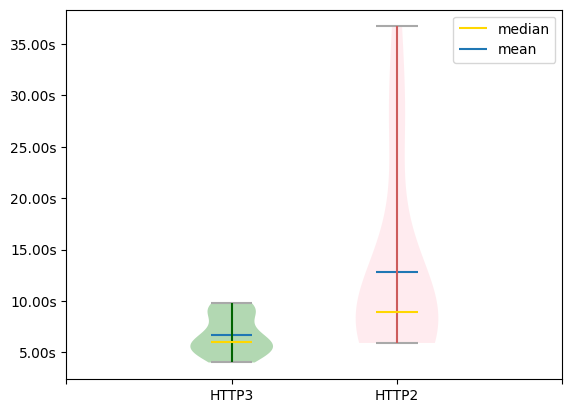

In [2]:
import collections
import datetime
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz


def json_from_file(path):
    f = open(path, "r")
    json_data = json.loads(f.read())
    return json_data


def to_timestamp(datetime_str):
    dt = datetime.datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    dt = dt.replace(tzinfo=pytz.UTC)
    timestamp = dt.timestamp() * 1000
    return int(timestamp)


def summarize_response_time(json_data, include_script=True):
    """
    :param json_data: raw json data from a har file
    :param include_script: If set to False, it stops counting time
           on the first request initiated by a script, not to include in the total time
           async requests from third party scripts.
    :return: summed response time, number of requests analyzed
    """
    request_time = 0.0
    start_time = 0.0
    i = 0

    for entry in json_data['log']['entries']:
        if entry['startedDateTime']:
            if not include_script and str(entry['_initiator_type']) == 'script':
                break

            if start_time == 0: start_time = to_timestamp(str(entry['startedDateTime']))

            request_time = to_timestamp(str(entry['startedDateTime'])) + int(entry['time'])
            i += 1

    return (request_time - start_time) / 1000, i


def get_number_of_requests(json_data, include_script=True):
    i = 0

    for entry in json_data['log']['entries']:
        if entry['startedDateTime']:
            if not include_script and str(entry['_initiator_type']) == 'script':
                break
            i += 1

    return i


def get_results(results_list, index, include_script=True):
    x = []
    y = []
    number_of_requests = []

    for i, entry in enumerate(results_list):
        number_of_requests.append(get_number_of_requests(entry, include_script))

    counter = collections.Counter(number_of_requests)
    most_common = counter.most_common(1)

    for i, entry in enumerate(results_list):
        summary, requests_count = summarize_response_time(entry, include_script)

        # Filter out tests with not matching number of requests.
        if requests_count == most_common[0][0]:
            x.append(index)
            y.append(summary)

    return x, y


def get_lowest_values(results, percentile):
    sorted_results = np.sort(results)
    index = int(len(sorted_results) * percentile / 100)
    lowest_values = sorted_results[:index]
    return lowest_values


def show_results(path, include_script=True):
    http3_list = []
    http2_list = []

    for file in glob.glob(path + '/http3/*.har'):
        data = json_from_file(file)
        http3_list.append(data)

    for file in glob.glob(path + '/http2/*.har'):
        data = json_from_file(file)
        http2_list.append(data)

    http3_x, http3_y = get_results(http3_list, 1, include_script)
    http2_x, http2_y = get_results(http2_list, 2, include_script)

    tableData = {
        'HTTP3': [
            np.median(http3_y),
            np.mean(http3_y),
            np.max(get_lowest_values(http3_y, 90)),
            np.max(get_lowest_values(http3_y, 99)),
            np.min(http3_y),
            np.max(http3_y)],
        'HTTP2': [
            np.median(http2_y),
            np.mean(http2_y),
            np.max(get_lowest_values(http2_y, 90)),
            np.max(get_lowest_values(http2_y, 99)),
            np.min(http2_y),
            np.max(http2_y)],
    }

    df = pd.DataFrame(tableData)
    df.index = ['median', 'mean', '90th percentile', '99th percentile', 'min', 'max']
    print(df)

    plot = plt.violinplot([http3_y, http2_y], showmedians=True, showmeans=True)
    plt.xticks(range(0, 4), ['', 'HTTP3', 'HTTP2', ''])
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2fs'))

    bgcolors = ['green', 'pink']
    mediancolors = ['gold', 'gold']
    barcolors = ['darkgreen', 'indianred']
    extremascolors = ['darkgray', 'darkgray']

    for patch, color in zip(plot['bodies'], bgcolors):
        patch.set_facecolor(color)
        patch.set_edgecolor(None)

    plot['cmedians'].set_colors(mediancolors)
    plot['cmedians'].set_label('median')
    plot['cmins'].set_colors(extremascolors)
    plot['cmaxes'].set_colors(extremascolors)
    plot['cbars'].set_colors(barcolors)

    plt.legend([plot['cmedians'], plot['cmeans']], ['median', 'mean'])
    plt.savefig(path + '/plot.svg')
    plt.show()


# Here custom metrics need to loaded
print("DE (Nürnberg):")
show_results('data/de', False)
print("FI (Helsinki):")
show_results('data/fi', False)
print("US (East Coast):")
show_results('data/us', False)
print("PL (fiber):")
show_results('data/pl-fiber', False)
print("PL mobile LTE:")
show_results('data/pl-mobile', False)
print("PL mobile poor quality ~15% packets loss:")
show_results('data/pl-mobile3g', False)
